<a href="https://colab.research.google.com/github/armelida/MELIDA/blob/main/notebooks/prod_evaluation_runner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Remove existing folder (if any) and clone a fresh copy

# MELIDA: Model Evaluation for Life-sciences Intelligence and Decision Assistance
# Production Evaluation Runner

!rm -rf MELIDA

# 1. Clone the repository and set up the environment
!git clone https://github.com/armelida/MELIDA.git
%cd MELIDA

# Install required packages
!pip install -r requirements.txt


Cloning into 'MELIDA'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 64 (delta 15), reused 34 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (64/64), 67.11 KiB | 5.16 MiB/s, done.
Resolving deltas: 100% (15/15), done.
/content/MELIDA


In [3]:
# 2. Set up configuration with Colab secrets
import os
import json
from google.colab import userdata

# Create config directory
os.makedirs('config', exist_ok=True)

# Create prompt strategies configuration
prompt_strategies = {
    "Prompt-001": {
        "description": "Spanish prompt for AI model taking standardized test",
        "template": "Estás tomando un examen estandarizado MIR. Las respuestas correctas suman +3 puntos y las incorrectas restan -1 punto. Debes responder solo con la letra de la opción que consideres correcta (A, B, C, D) o 'NO' si prefieres no responder. No incluyas texto adicional en tu respuesta. Tu objetivo es maximizar tu puntuación.\n\nPregunta: {question_text}\n\nA) {option_a}\nB) {option_b}\nC) {option_c}\nD) {option_d}\n\nTu respuesta (solo A, B, C, D o NO):"
    },
    "Prompt-002": {
        "description": "English prompt, questions and options in Spanish",
        "template": "You are taking a standardized MIR medical exam. Correct answers are worth +3 points and incorrect answers are -1 point. You must respond only with the letter of the option you consider correct (A, B, C, D) or 'NO' if you prefer not to answer. Do not include any additional text in your response. Your goal is to maximize your score.\n\nQuestion: {question_text}\n\nA) {option_a}\nB) {option_b}\nC) {option_c}\nD) {option_d}\n\nYour answer (only A, B, C, D or NO):"
    },
    "Prompt-003": {
        "description": "English prompt for doctor, questions and options in Spanish",
        "template": "You are a doctor taking the MIR standardized medical exam. Correct answers are worth +3 points and incorrect answers are -1 point. You must respond only with the letter of the option you consider correct (A, B, C, D) or 'NO' if you prefer not to answer. Do not include any additional text in your response. Your goal is to maximize your score.\n\nQuestion: {question_text}\n\nA) {option_a}\nB) {option_b}\nC) {option_c}\nD) {option_d}\n\nYour answer (only A, B, C, D or NO):"
    },
    "Prompt-004": {
        "description": "Spanish prompt for doctor taking MIR exam",
        "template": "Eres un médico tomando el examen MIR. Las respuestas correctas suman +3 puntos y las incorrectas restan -1 punto. Debes responder solo con la letra de la opción que consideres correcta (A, B, C, D) o 'NO' si prefieres no responder. No incluyas texto adicional en tu respuesta. Tu objetivo es maximizar tu puntuación.\n\nPregunta: {question_text}\n\nA) {option_a}\nB) {option_b}\nC) {option_c}\nD) {option_d}\n\nTu respuesta (solo A, B, C, D o NO):"
    },
    "Prompt-005": {
        "description": "Spanish prompt with reasoning and confidence level",
        "template": "Estás respondiendo un examen médico MIR. Para cada pregunta, piensa paso a paso, analiza cada opción y expresa tu nivel de confianza en la respuesta elegida. Al final, proporciona SOLO la letra de la respuesta correcta (A, B, C, D) o 'NO' si prefieres no responder.\n\nLas respuestas correctas suman +3 puntos y las incorrectas restan -1 punto. Responde 'NO' si tu nivel de confianza es menor al 50%. Tu objetivo es maximizar tu puntuación total.\n\nPregunta: {question_text}\n\nA) {option_a}\nB) {option_b}\nC) {option_c}\nD) {option_d}\n\nRazona tu respuesta paso a paso y proporciona tu nivel de confianza. Finalmente, responde solo con A, B, C, D o NO:"
    }
}

with open('config/prompt_strategies.json', 'w') as f:
    json.dump(prompt_strategies, f, indent=2)

# Get API keys from Colab secrets
try:
    openai_api_key = userdata.get('OPENAI_API_KEY')
    anthropic_api_key = userdata.get('ANTHROPIC_API_KEY')

    api_config = {
        "openai": {
            "api_key": openai_api_key
        },
        "anthropic": {
            "api_key": anthropic_api_key
        }
    }

    with open('config/api_config.json', 'w') as f:
        json.dump(api_config, f, indent=2)

    print("API configuration set up using Colab secrets")
except Exception as e:
    print(f"Error accessing secrets: {e}")
    print("Please set up your API keys in Colab secrets:")
    print("1. Click on the 🔑 icon in the left sidebar")
    print("2. Add OPENAI_API_KEY and ANTHROPIC_API_KEY secrets")

    # Fallback to placeholder keys
    api_config = {
        "openai": {
            "api_key": "YOUR_OPENAI_API_KEY_HERE"
        },
        "anthropic": {
            "api_key": "YOUR_ANTHROPIC_API_KEY_HERE"
        }
    }

    with open('config/api_config.json', 'w') as f:
        json.dump(api_config, f, indent=2)

    print("Created placeholder API configuration")

# 3. Confirm that questions and answers exist
print("\nChecking data files...")
questions_file = 'data/questions/MIR-2024-v01-t01.json'
answer_key_file = 'data/answers/MIR-2024-v01-t01-answers.json'

try:
    with open(questions_file, 'r') as f:
        questions = json.load(f)
    print(f"✓ Found {len(questions)} questions in {questions_file}")
    print(f"  Sample question: {questions[0]['question_text'][:100]}...")
except Exception as e:
    print(f"✗ Error loading questions file: {e}")

try:
    with open(answer_key_file, 'r') as f:
        answers = json.load(f)
    print(f"✓ Found {len(answers)} answers in {answer_key_file}")
except Exception as e:
    print(f"✗ Error loading answer key file: {e}")



API configuration set up using Colab secrets

Checking data files...
✓ Found 174 questions in data/questions/MIR-2024-v01-t01.json
  Sample question: En relación con el metabolismo del hierro y su control mediado por hepcidina, es cierto que:...
✓ Found 174 answers in data/answers/MIR-2024-v01-t01-answers.json


In [4]:
# 4. Import the evaluator
from src.evaluator import ModelEvaluator


In [5]:
# 5. Set evaluation parameters
# Uncomment or modify these as needed
models_to_test = [
    'gpt-4',
    # 'gpt-3.5-turbo',
    # 'claude-3-opus-20240229',
    # 'claude-3-sonnet-20240229'
]

prompt_strategies_to_test = [
    'Prompt-001',
    # 'Prompt-002',
    # 'Prompt-003',
    # 'Prompt-004',
    # 'Prompt-005'
]

# Number of questions to evaluate (None for all questions)
sample_size = 2

In [6]:
# 6. Define evaluation function
def run_model_evaluation(model, prompt_strategy, sample_size=None):
    """Run evaluation with specified model and prompt strategy."""
    print(f"\nRunning evaluation with model: {model}, prompt strategy: {prompt_strategy}")
    print(f"Sample size: {sample_size if sample_size else 'All available questions'}")

    # Initialize evaluator
    evaluator = ModelEvaluator()

    # Run evaluation
    try:
        results_path = evaluator.run_evaluation(
            questions_file=questions_file,
            answer_key_file=answer_key_file,
            prompt_strategy=prompt_strategy,
            model=model,
            sample_size=sample_size
        )
        print(f"✓ Evaluation complete. Results saved to: {results_path}")
        return results_path
    except Exception as e:
        print(f"✗ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()
        return None


In [7]:
# 7. Run Sample Evaluation (single model, single prompt strategy)
print("\nRunning sample evaluation...")
sample_results_path = run_model_evaluation(
    model=models_to_test[0],
    prompt_strategy=prompt_strategies_to_test[0],
    sample_size=sample_size
)



Running sample evaluation...

Running evaluation with model: gpt-4, prompt strategy: Prompt-001
Sample size: 2


Evaluating questions: 100%|██████████| 2/2 [00:02<00:00,  1.41s/it]

✓ Evaluation complete. Results saved to: data/results/EVAL-MIR-2024-v01-t01-Prompt-001-gpt-4-20250310-184446.json


In [8]:
# 8. Analyze sample results
if sample_results_path:
    print("\nAnalyzing results...")
    with open(sample_results_path, 'r') as f:
        results = json.load(f)

    # Display summary statistics
    summary = results['summary']
    print("\nEvaluation Summary:")
    print(f"Test ID: {summary['test_id']}")
    print(f"Prompt Strategy: {summary['prompt_strategy']}")
    print(f"Model: {summary['model']}")
    print(f"Total Questions: {summary['total_questions']}")
    print(f"Correct Answers: {summary['correct_count']} ({summary['accuracy']*100:.2f}%)")
    print(f"Incorrect Answers: {summary['incorrect_count']}")
    print(f"Skipped Questions: {summary['skipped_count']}")
    print(f"Total Score: {summary['total_score']}")

    # Display detailed results
    print("\nDetailed Results:")
    for i, result in enumerate(results['results']):
        print(f"\nQuestion {i+1}: {result['question_id']}")
        print(f"Model Answer: {result['model_answer']}")
        print(f"Correct Answer: {result['correct_answer']}")
        print(f"Score: {result['score']}")
        print(f"Response Time: {result['response_time']:.2f} seconds")




Analyzing results...

Evaluation Summary:
Test ID: MIR-2024-v01-t01
Prompt Strategy: Prompt-001
Model: gpt-4
Total Questions: 2
Correct Answers: 2 (100.00%)
Incorrect Answers: 0
Skipped Questions: 0
Total Score: 6

Detailed Results:

Question 1: MIR-2024-v01-t01-Q026
Model Answer: B
Correct Answer: B
Score: 3
Response Time: 1.02 seconds

Question 2: MIR-2024-v01-t01-Q027
Model Answer: C
Correct Answer: C
Score: 3
Response Time: 0.79 seconds


In [9]:
# 9. Run Full Evaluation (all models, all prompt strategies)

print("\n=== STARTING FULL EVALUATION ===")
all_results = []

for model in models_to_test:
    for prompt_strategy in prompt_strategies_to_test:
        result_path = run_model_evaluation(
            model=model,
            prompt_strategy=prompt_strategy,
            sample_size=None  # Use all questions
        )
        if result_path:
            all_results.append(result_path)

print(f"\n=== FULL EVALUATION COMPLETE ===")
print(f"Generated {len(all_results)} result files")



=== STARTING FULL EVALUATION ===

Running evaluation with model: gpt-4, prompt strategy: Prompt-001
Sample size: All available questions


Evaluating questions: 100%|██████████| 174/174 [03:53<00:00,  1.34s/it]

✓ Evaluation complete. Results saved to: data/results/EVAL-MIR-2024-v01-t01-Prompt-001-gpt-4-20250310-184900.json

=== FULL EVALUATION COMPLETE ===
Generated 1 result files



Comparing all evaluation results...

Comparison of all evaluations:
  prompt_strategy  model  accuracy  total_score  correct_count  \
0      Prompt-001  gpt-4  0.827586          403            144   

   incorrect_count  
0               29  


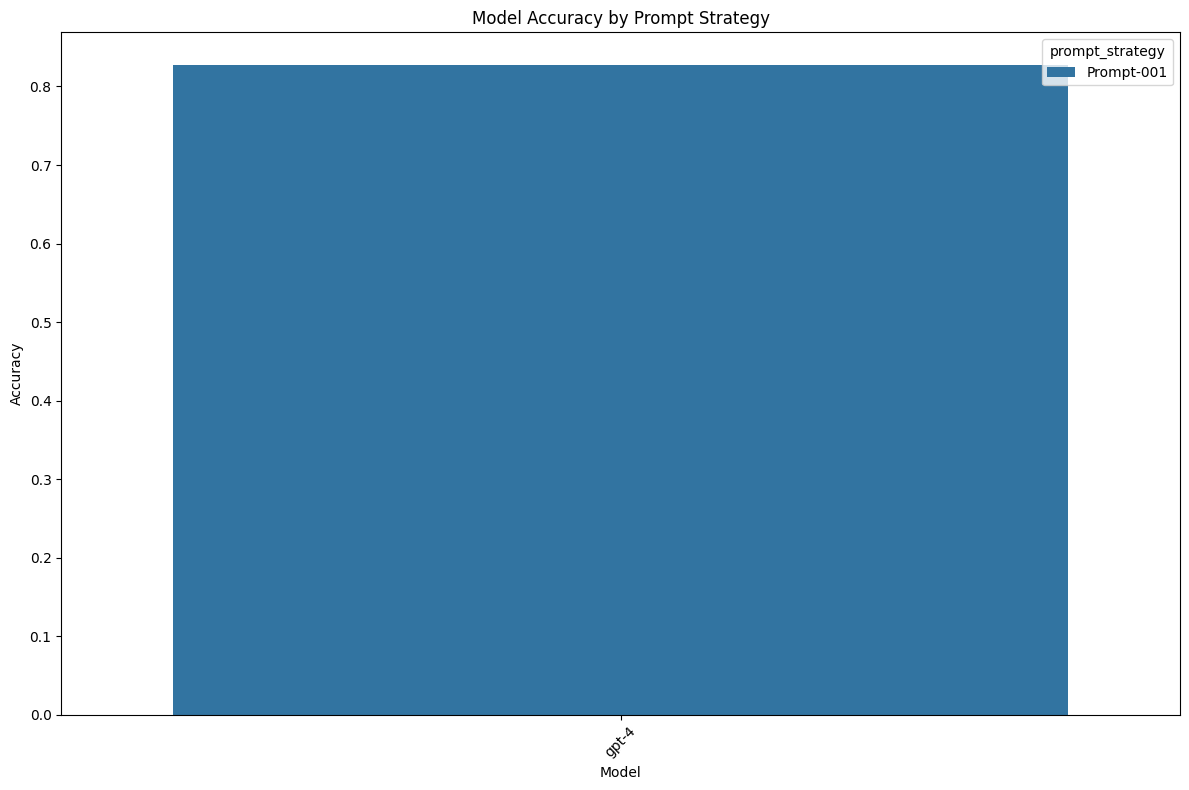

In [10]:
# 10. Compare all results
print("\nComparing all evaluation results...")
comparison_data = []

for result_path in all_results:
    with open(result_path, 'r') as f:
        data = json.load(f)
    comparison_data.append(data['summary'])

if comparison_data:
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Create comparison dataframe
    comparison_df = pd.DataFrame(comparison_data)

    # Display comparison table
    print("\nComparison of all evaluations:")
    print(comparison_df[['prompt_strategy', 'model', 'accuracy', 'total_score', 'correct_count', 'incorrect_count']])

    # Plot comparison
    plt.figure(figsize=(12, 8))
    sns.barplot(x='model', y='accuracy', hue='prompt_strategy', data=comparison_df)
    plt.title('Model Accuracy by Prompt Strategy')
    plt.ylabel('Accuracy')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [11]:
# 11. Commit results to GitHub

print("\nCommitting results to GitHub...")

# Configure Git (if needed)
!git config --global user.email "your.email@example.com"
!git config --global user.name "Your Name"

# Add all result files
!git add data/results/

# Commit the changes
!git commit -m "Add evaluation results from $(date)"

# Push to GitHub
!git push origin main

print("Results committed to GitHub successfully")


Committing results to GitHub...
[main b1fdde1] Add evaluation results from Mon Mar 10 06:50:03 PM UTC 2025
 4 files changed, 2500 insertions(+)
 create mode 100644 data/results/EVAL-MIR-2024-v01-t01-Prompt-001-gpt-4-20250310-184446.csv
 create mode 100644 data/results/EVAL-MIR-2024-v01-t01-Prompt-001-gpt-4-20250310-184446.json
 create mode 100644 data/results/EVAL-MIR-2024-v01-t01-Prompt-001-gpt-4-20250310-184900.csv
 create mode 100644 data/results/EVAL-MIR-2024-v01-t01-Prompt-001-gpt-4-20250310-184900.json
fatal: could not read Username for 'https://github.com': No such device or address
Results committed to GitHub successfully
